<a href="https://colab.research.google.com/github/Monzikov/MyColabs/blob/main/%D0%9A%D1%83%D1%80%D1%81%D0%BE%D0%B2%D0%BE%D0%B9_%D0%BF%D1%80%D0%BE%D0%B5%D0%BA%D1%82_%D0%BF%D0%BE_%D0%91%D0%B0%D0%B7%D0%BE%D0%B2%D0%BE%D0%BC%D1%83_Python_%D0%9C%D0%BE%D0%BD%D0%B7%D0%B8%D0%BA%D0%BE%D0%B2_%D0%AE_%D0%9D_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Подготовка окружения

```
Установка необходимых библиотек.
Скачивание данных.
Настройка логирования.
```



In [1]:
!pip install sweetviz
!pip install kaggle
!kaggle datasets list

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 407, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/


Настройка логирования

In [2]:
import logging

time_format = "%Y-%m-%d %H:%M:%S"
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s",datefmt=time_format, filename='execution.log', filemode='a', force=True)
logging.info("Проверка логирования.")

# 2.Скачивание датасета со стоимостью автомобилей в директорию datasets.

```
Для анализа был выбран датасет со стоимостью автомобилей с Kaggle.
```
[Ссылка на источник](https://www.kaggle.com/datasets/CooperUnion/cardataset)

Путь к файлу датасета сохраняем в переменную **dataset_file_path**

In [3]:
import kagglehub
import shutil
import os

Datasets_dir = './datasets'
Dataset_filename = 'cardataset.csv'
if not os.path.exists(Datasets_dir):
    os.mkdir(Datasets_dir)

file_path = kagglehub.dataset_download('CooperUnion/cardataset', path='data.csv', )
dataset_file_path = shutil.copy(file_path, f"{Datasets_dir}/{Dataset_filename}")

# 3.Конфигурирование
```
Установка значений в файл конфигурации.
```

In [4]:
import json


class ConfigManager:
    """
    Класс управления конфигурацией
    """

    def __init__(self, ds_dir="./datasets", ds_name="dataset.csv", rp_dir="./reports"):
        self.config = config = {
            "datasets_dir": ds_dir,
            "file_name": ds_name,
            "output_dir": rp_dir,
        }
        self.cfname = "config.json"

    def SaveConfig(self):
        cfg_file = open(self.cfname, "w")
        json.dump(self.config, cfg_file, indent=4)
        cfg_file.close()

    def LoadConfig(self):
        with open(self.cfname, "r") as f:
            self.config = json.load(f)

    def GetConfig(self):
        return self.config

    def GetConfigValue(self, key):
        return self.config[key]

    def SetConfigValue(self, key, value):
        self.config[key] = value

    def ChangeValuePrompt(self, key, prompt):
        val = input(
            f"{prompt} Текущее значение {key} = {self.GetConfigValue(key)}.\nНажмите <Enter> чтобы отказаться от изменений."
        )
        if val != "":
            self.SetConfigValue(key, val)

    def __repr__(self):
        return (
            "Текущие настройки\n\n"
            + "\n".join([f"{i}:{self.config[i]}" for i in self.config])
            + "\n"
        )

    def __str__(self):
        return self.__repr__()


Инициациализация конфигурации.

In [5]:
cm = ConfigManager(Datasets_dir, Dataset_filename)
cm

Текущие настройки

datasets_dir:./datasets
file_name:cardataset.csv
output_dir:./reports

Изменить значения конфигурации.
```
Убрав комментарии можно в интерактивном режиме обновить значения файла конфигурации
```

In [6]:
# cm.ChangeValuePrompt('datasets_dir','Укажите новое зачение для каталога датасетов. ')
# cm.ChangeValuePrompt('file_name','Укажите новое значение имени файла с данными. ')
# cm.ChangeValuePrompt('output_dir','Укажите новое зачение для каталога отчетов. ')
# cm.SaveConfig()

# 4.Программа "EDA" - Исследовательский Анализ Данных

In [7]:
import pandas as pd
import sweetviz as sv
from abc import ABC, abstractmethod


class Handler(ABC):
    """
    Абстрактный базовый класс для всех обработчиков.
    """

    def __init__(self):
        self.next_handler = None

    def set_next(self, handler):
        """Устанавливает следующий обработчик в цепочке."""
        self.next_handler = handler
        return handler

    @abstractmethod
    def handle(self, data):
        """Обрабатывает данные и передает их следующему обработчику."""
        if self.next_handler:
            return self.next_handler.handle(data)
        return data


class OpenCsvHandler(Handler):
    """
    Шаг открытия CSV файла.
    """

    def __init__(self, file_path, file_name):
        super().__init__()
        self.file_path = file_path
        self.file_name = file_name

    def handle(self, data):
        # Полный путь к файлу
        dataset_path = os.path.join(self.file_path, self.file_name)

        # Проверка существования файла
        if not os.path.exists(dataset_path):
            raise FileNotFoundError(
                f"Файл {self.file_name} не найден по пути {self.file_path}."
            )

        logging.info(f"Чтение данных из файла {self.file_name}...")
        data["df"] = pd.read_csv(dataset_path)
        logging.info("Данные успешно загружены.")
        return super().handle(data)


class CleanDataHandler(Handler):
    """
    Шаг очистки и обработки данных. Доступные операции: "drop_duplicates","fillna"
    """

    def __init__(self, fillna=True, drop_duplicates=True):
        super().__init__()
        self.fillna = fillna
        self.drop_duplicates = drop_duplicates

    def handle(self, data):
        df = data.get("df")
        if df is None:
            raise ValueError("Данные отсутствуют для обработки.")
        if self.fillna or self.drop_duplicates:
            if self.drop_duplicates:
                logging.info("Удаление дублей...")
                df.drop_duplicates(inplace=True)
            if self.fillna:
                logging.info("Обработка пропусков...")
                for col in df.columns:
                    if df[col].isnull().any():
                        if df[col].dtype == "object":
                            df.fillna({col: df[col].mode()[0]}, inplace=True)
                        else:
                            df.fillna({col: df[col].median()}, inplace=True)
                data["df"] = df
                logging.info("Данные очищены.")
        else:
            logging.info("Операции очистки данных не выполнялись")
        return super().handle(data)


class SweetvizHandler(Handler):
    """
    Шаг генерации отчета Sweetviz.
    """

    def __init__(self, output_dir, output_filename="sweetviz_report.html"):
        super().__init__()
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        pre, ext = os.path.splitext(output_filename)
        self.report_path = os.path.join(output_dir, pre + ".html")


    def handle(self, data):
        df = data.get("df")
        if df is None:
            raise ValueError("Нет данных для создания отчета Sweetviz.")

        logging.info("Генерация отчета Sweetviz...")
        report = sv.analyze(df)
        data["report"] = report
        report.show_html(filepath=self.report_path)
        logging.info(f"Отчет Sweetviz сохранен: {self.report_path}")
        return super().handle(data)


class InitChain(Handler):
    """
    Пустой обработчик для инициализации цепочки
    """

    def handle(self, data):
        logging.info("Начало выполнения цепочки анализа данных.")
        return super().handle(data)


class ShowReport(Handler):
    """
    Обработчик вызова отображения отчета в Colab
    """

    def handle(self, data):
        logging.info("Отображение отчета")
        if data is not None:
            report = data.get("report")
            report.show_notebook()
        else:
            raise ValueError("Отчёт не доступен для отображения.")
        return super().handle(data)


class EDAFlow:
    """
    Управление цепочкой обязанностей.
    """

    def __init__(self, config):
        self.config = config
        self.chain = None

    def build_chain(self):
        """
        Создает цепочку обязанностей.
        """
        self.chain = InitChain()
        self.chain.set_next(OpenCsvHandler(file_path=self.config["datasets_dir"], file_name=self.config["file_name"])
        ).set_next(CleanDataHandler()
        ).set_next(SweetvizHandler(output_dir=self.config["output_dir"], output_filename=self.config["file_name"])
        ).set_next(ShowReport())

    def execute_chain(self):
        """
        Запуск цепочки обязанностей.
        """
        if self.chain is None:
            raise RuntimeError("Цепочка не была построена.")
        self.chain.handle(data={})

    def Run(self):
        """
        Создание и запуск цепочки обязанностей.
        """
        try:
          self.build_chain()
          self.execute_chain()
        except Exception as e:
          logging.error(e)

# 5.Построение отчета EDA

```
- Cохранение настоек sweetviz
- Создание экземлпяра класса EDAFlow
- Запуск цепочки обработки
```



                                             |          | [  0%]   00:00 -> (? left)

Report ./reports/cardataset.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.



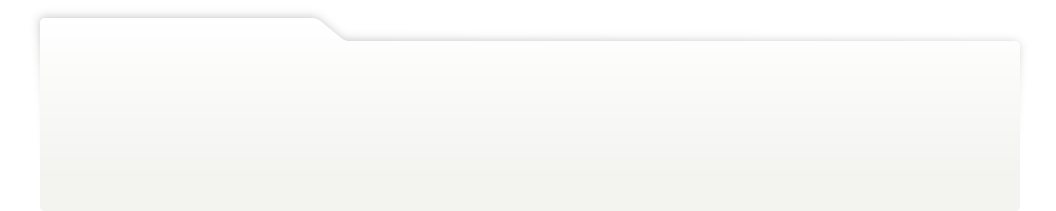
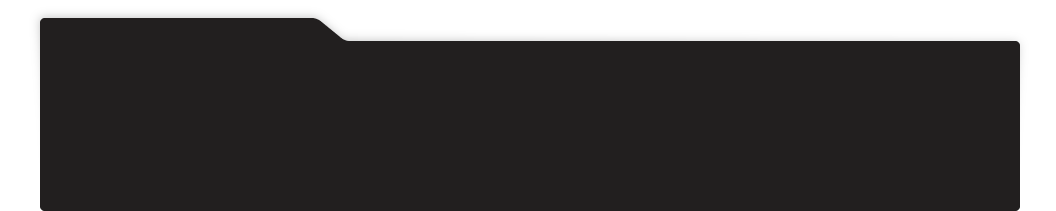
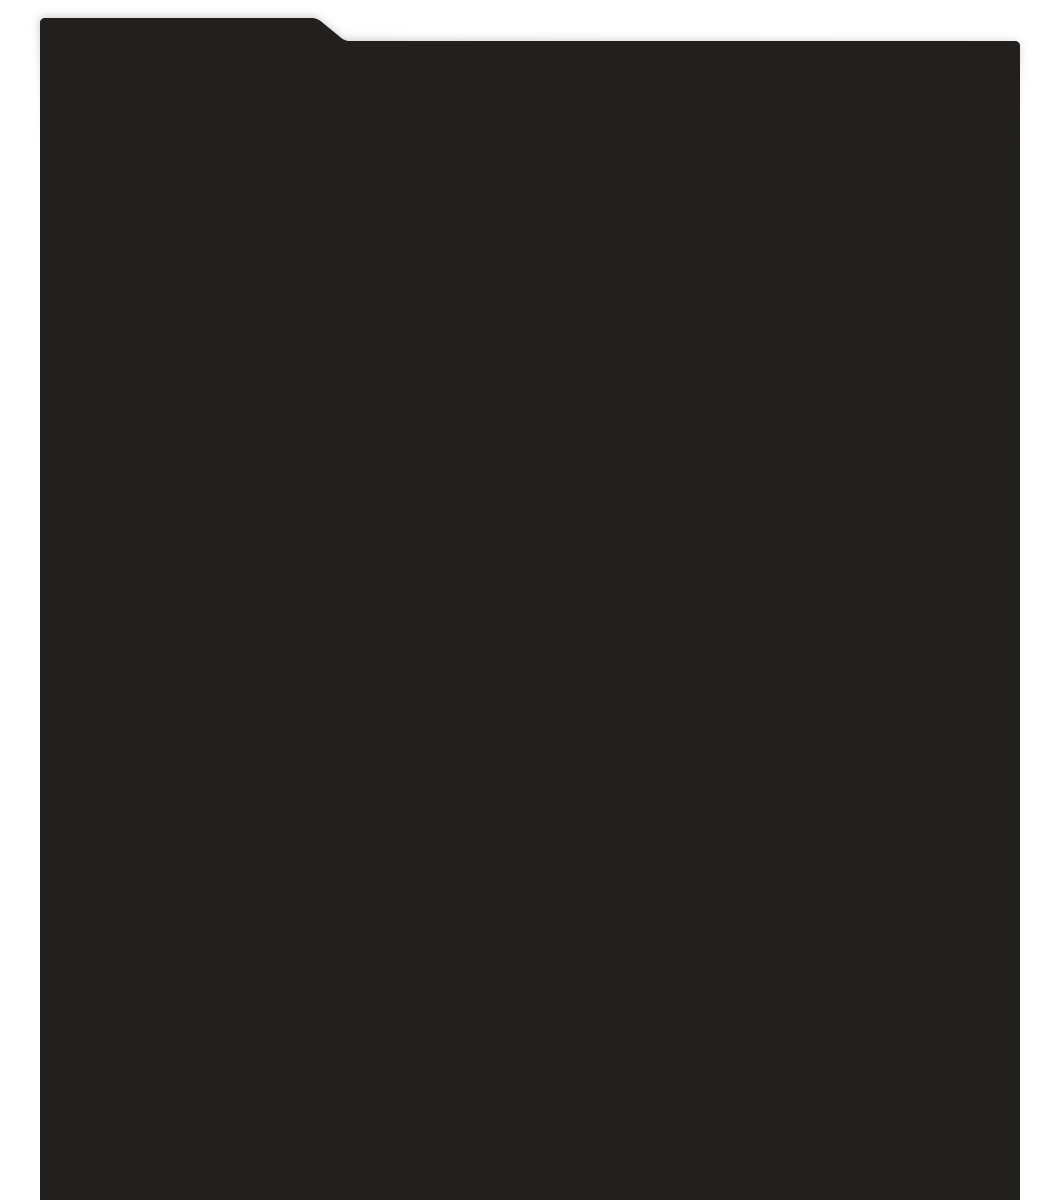
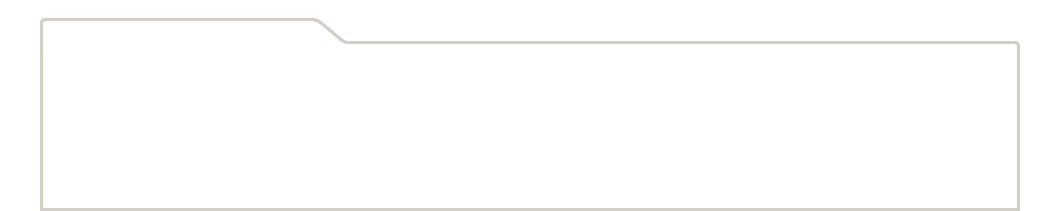
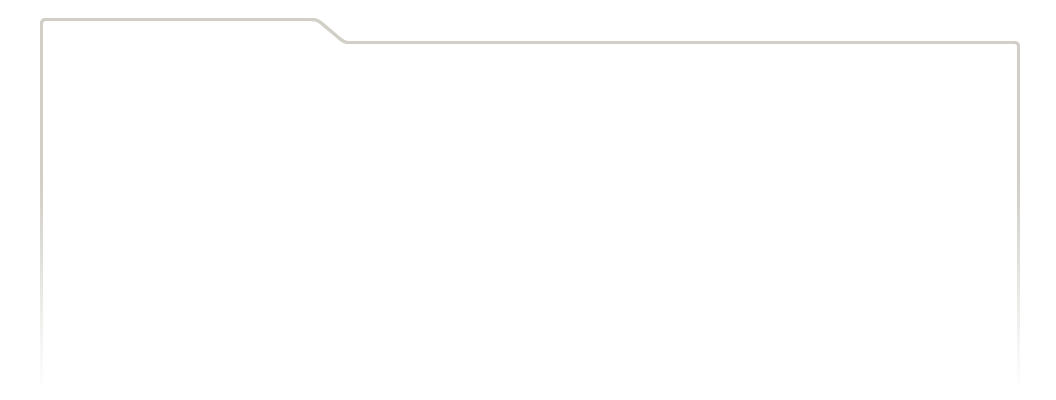
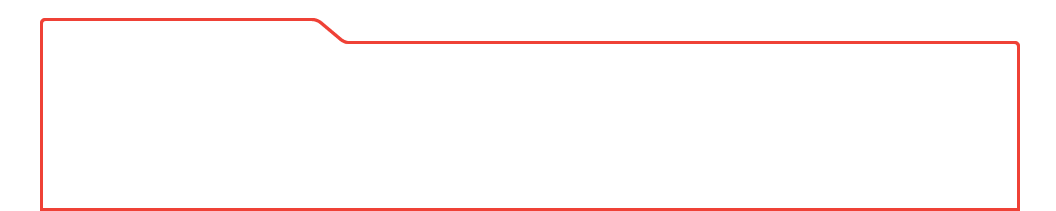
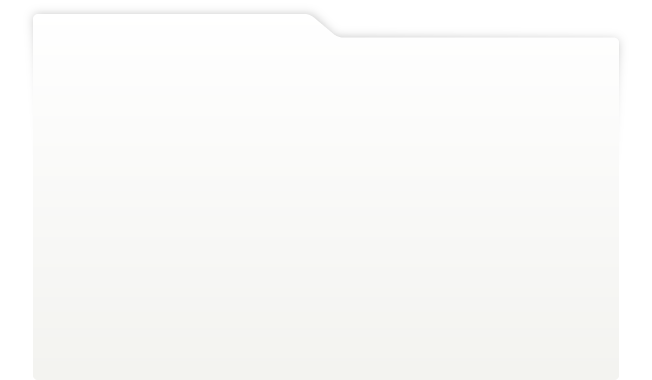
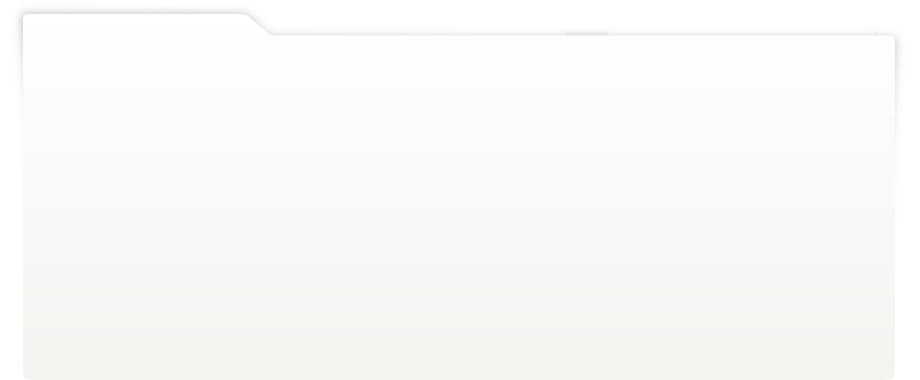
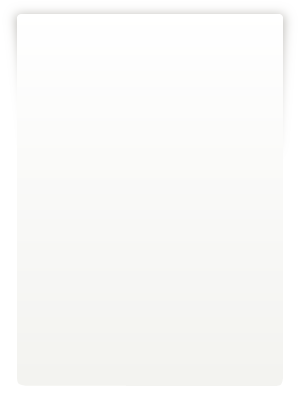
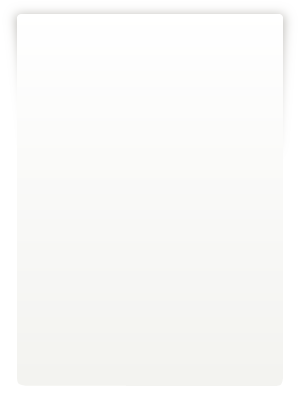
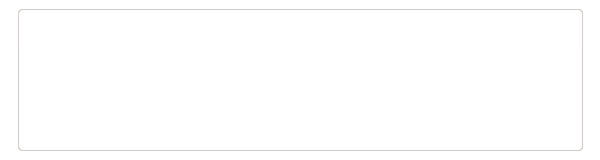
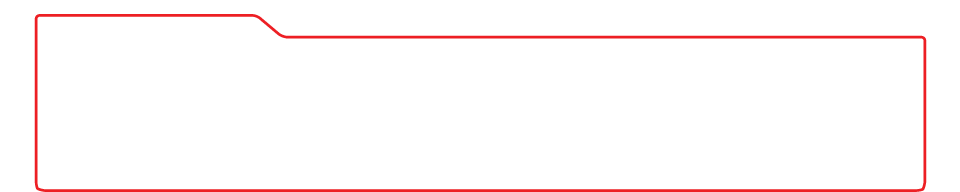
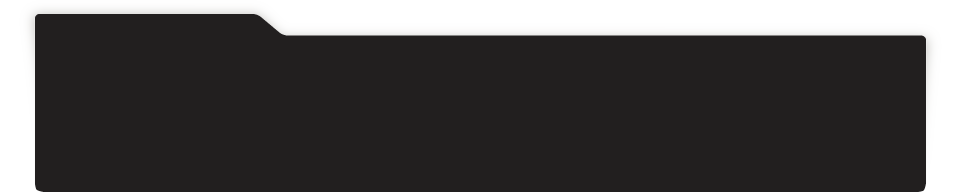
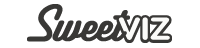
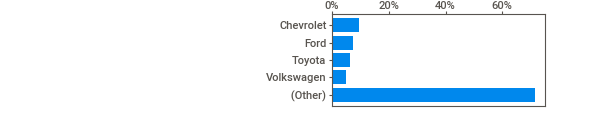
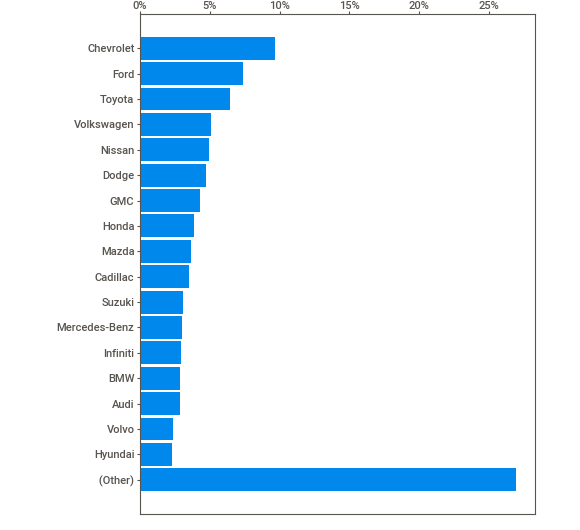
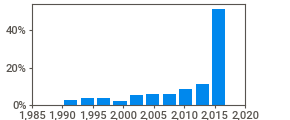
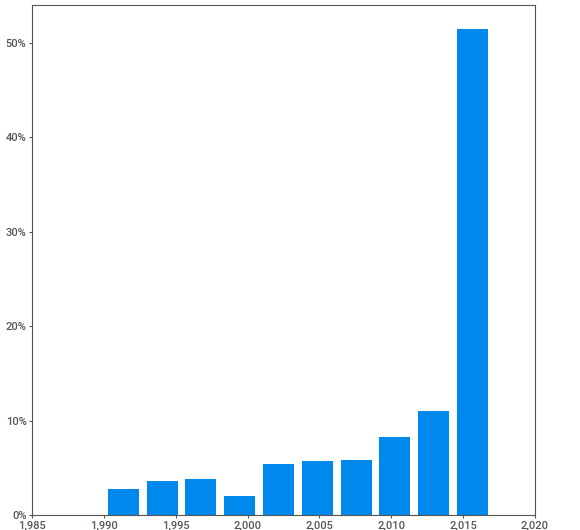
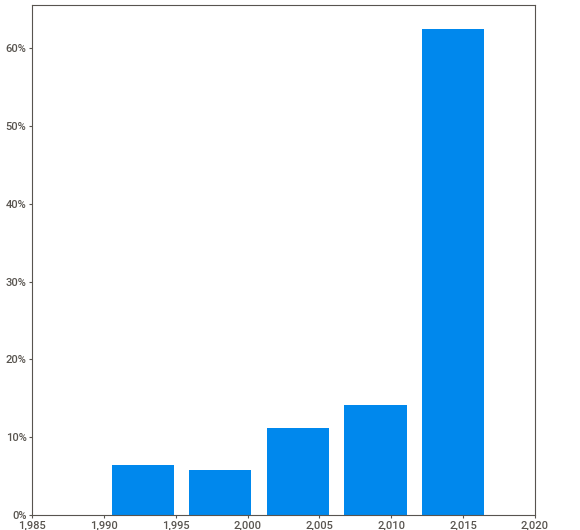
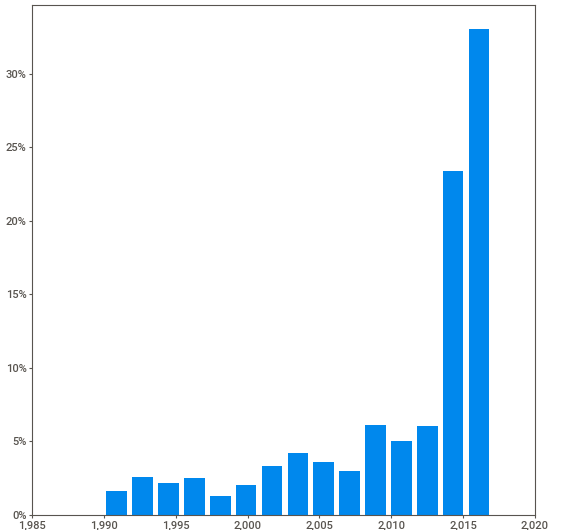
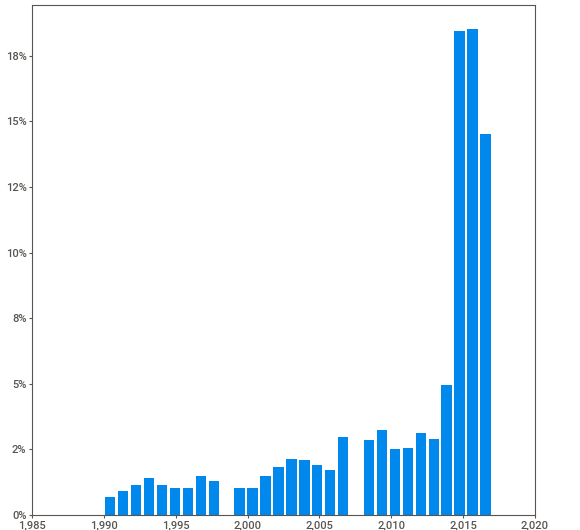
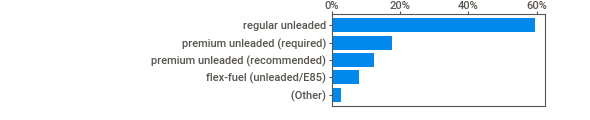
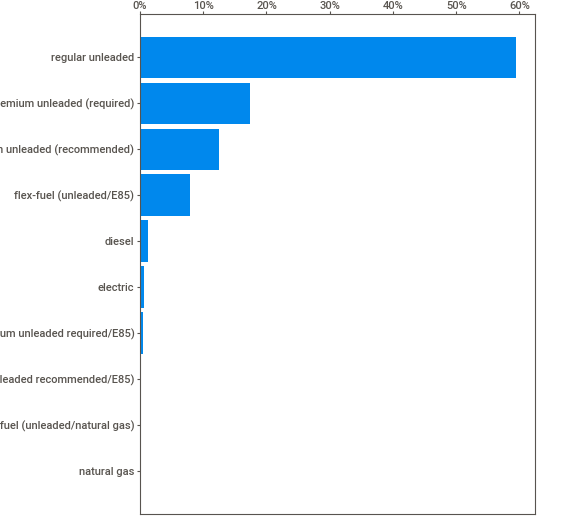
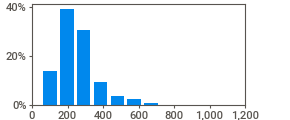
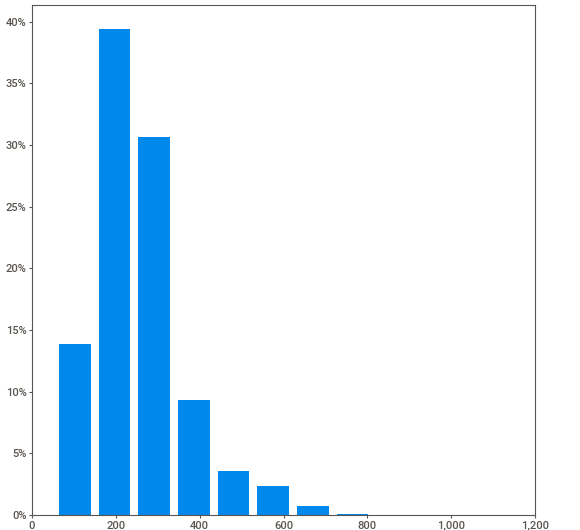
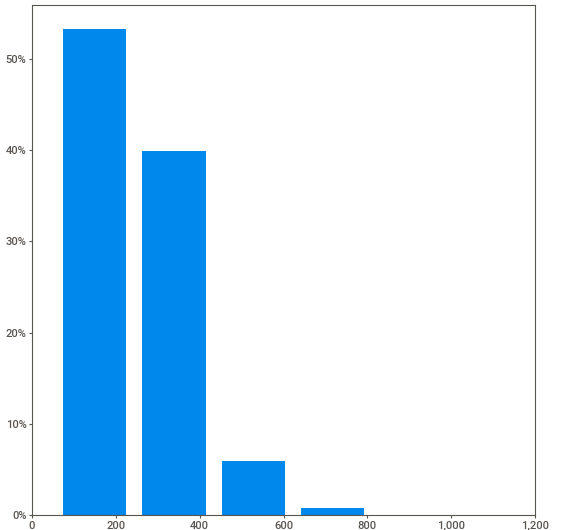
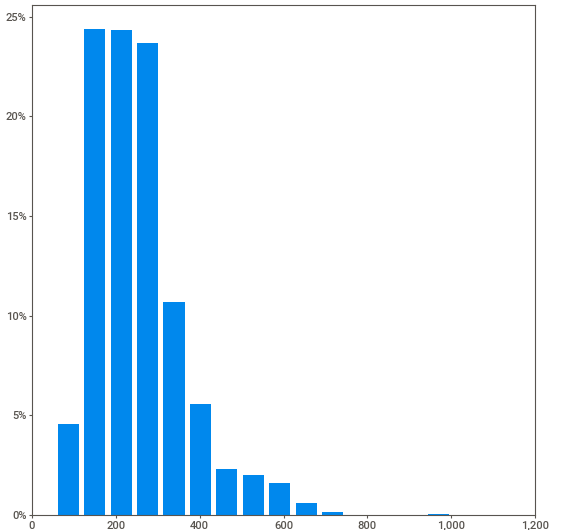
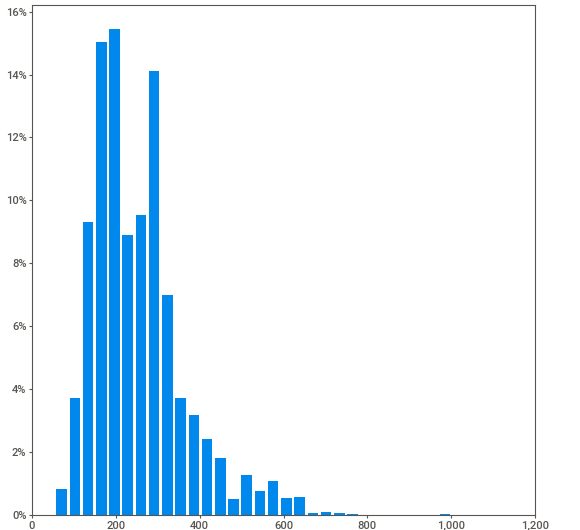
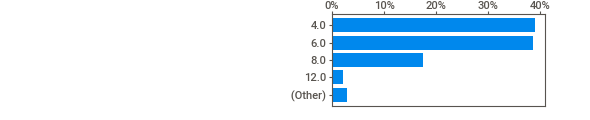
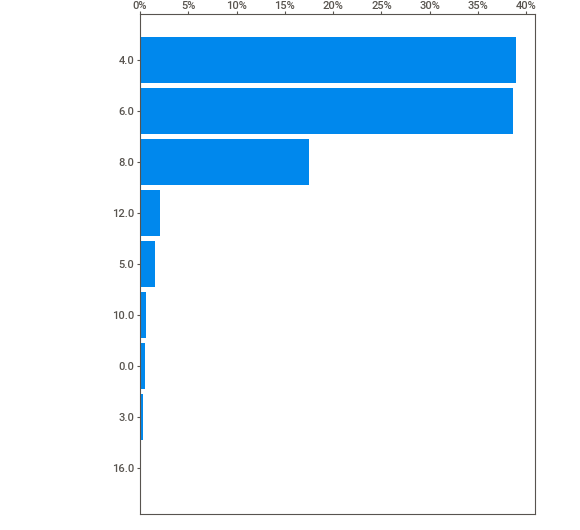
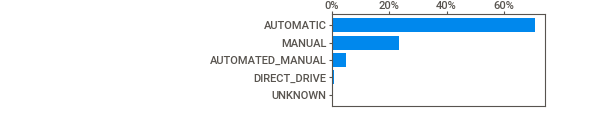
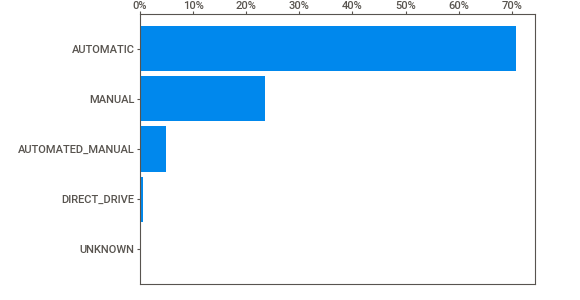
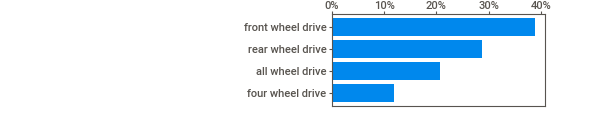
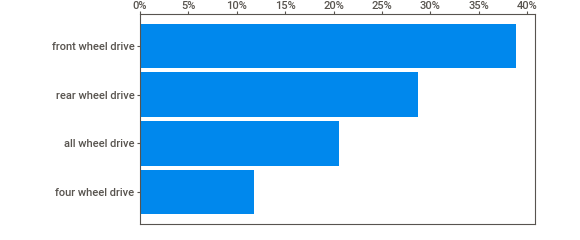
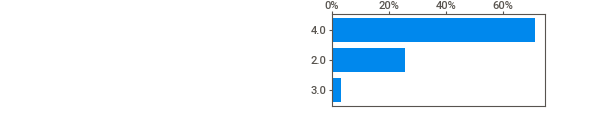
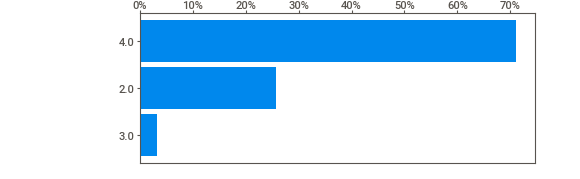
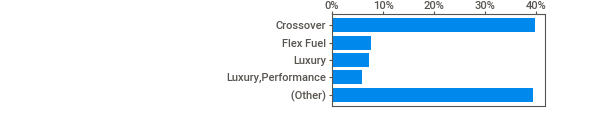
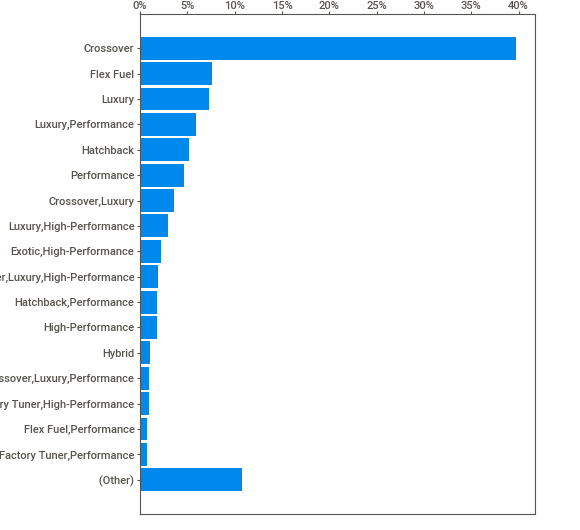
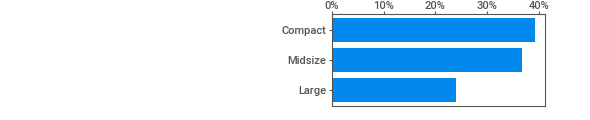
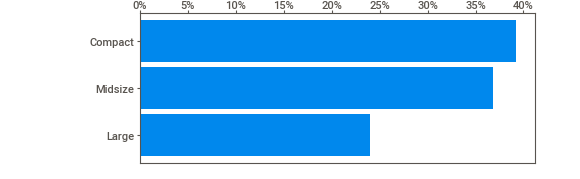
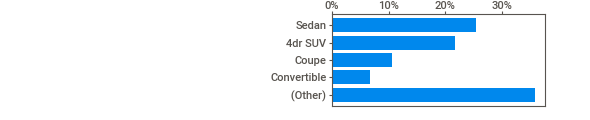
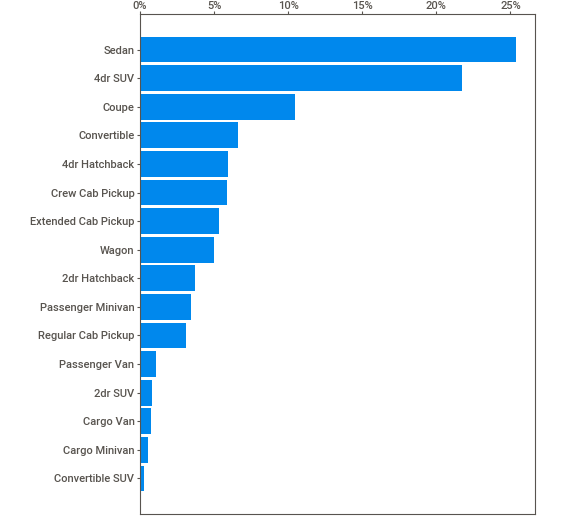
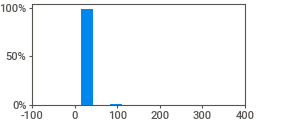
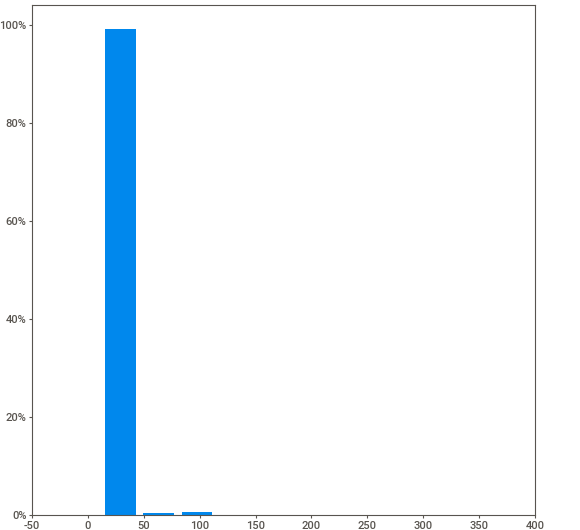
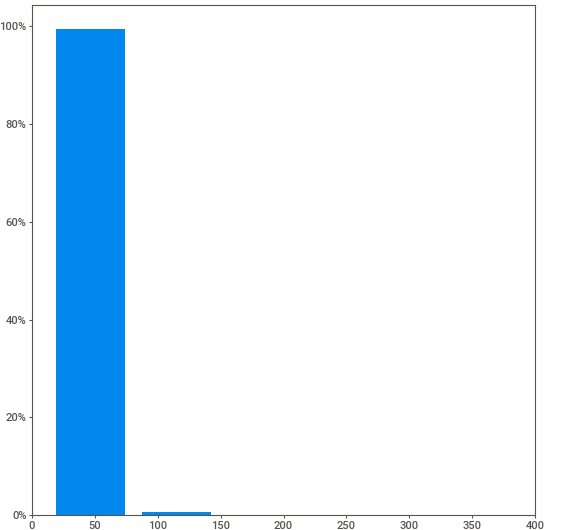
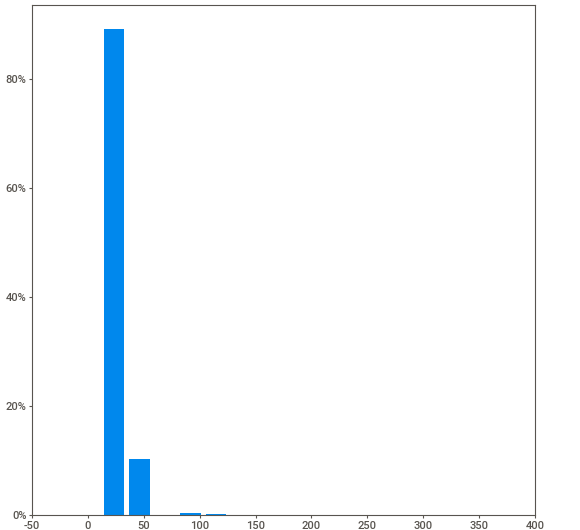
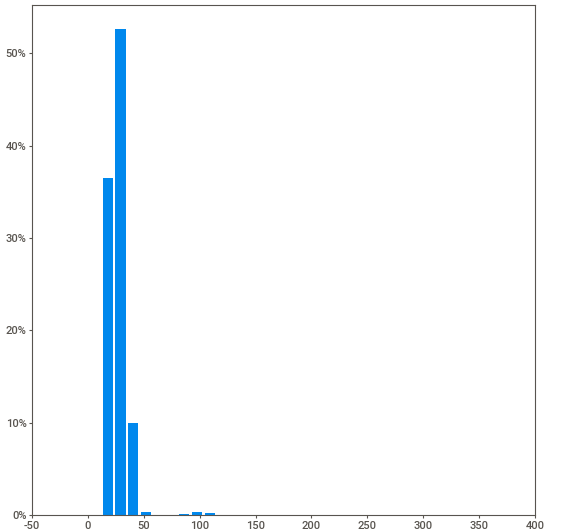
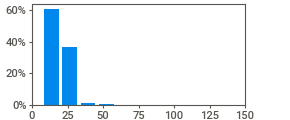
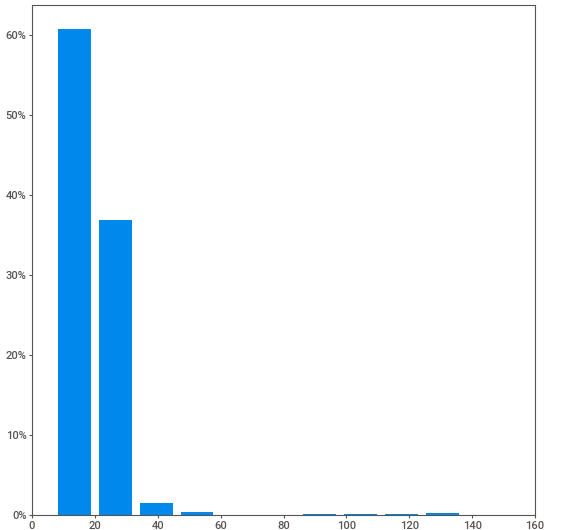
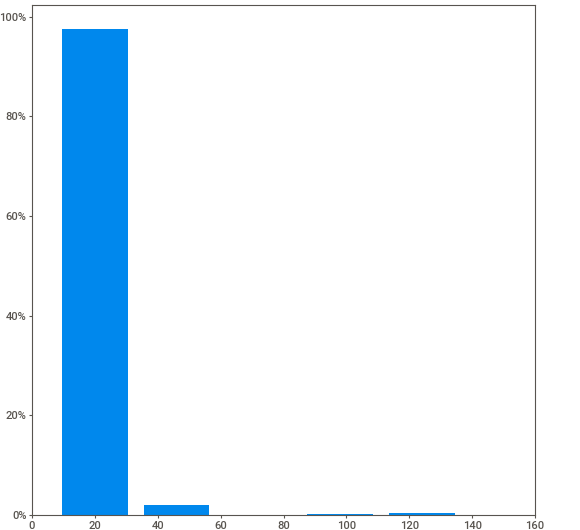
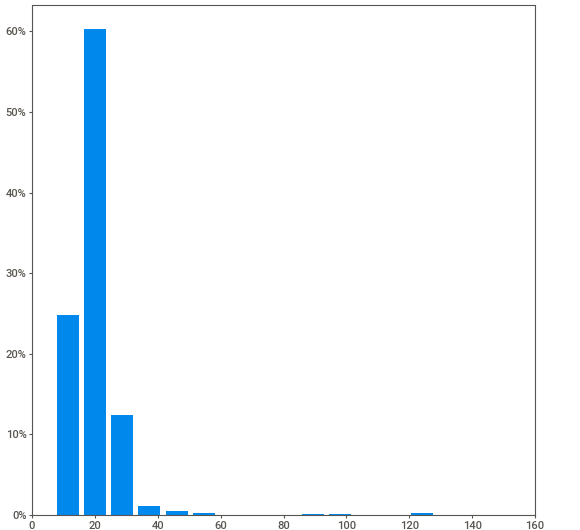
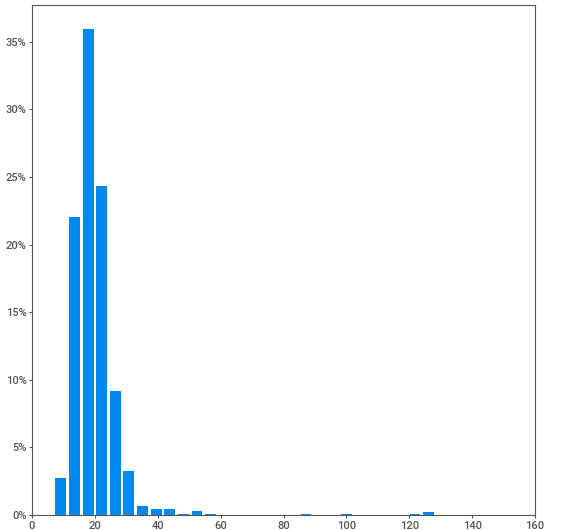
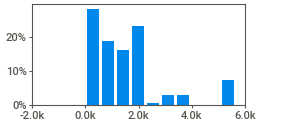
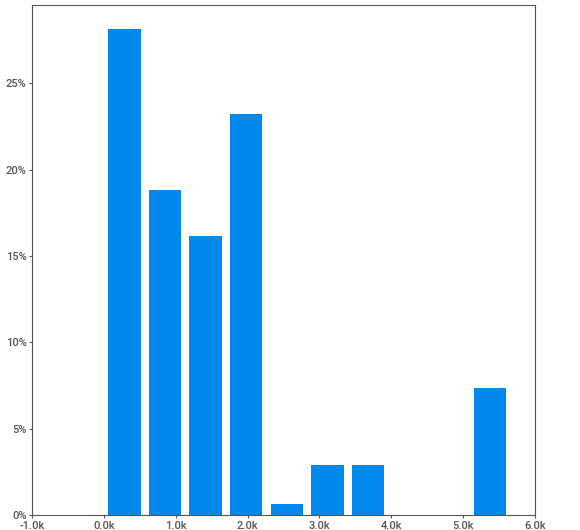
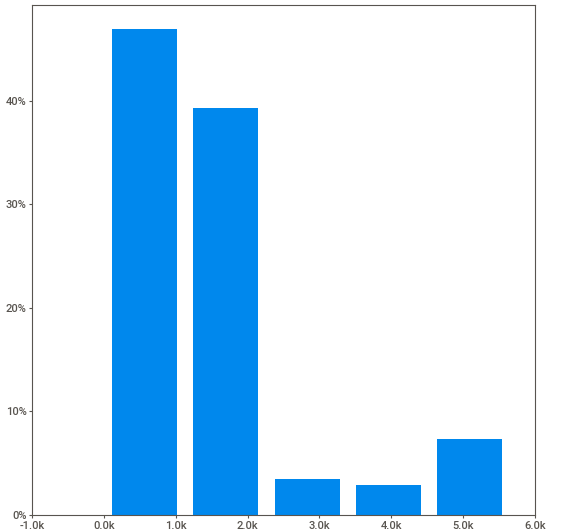
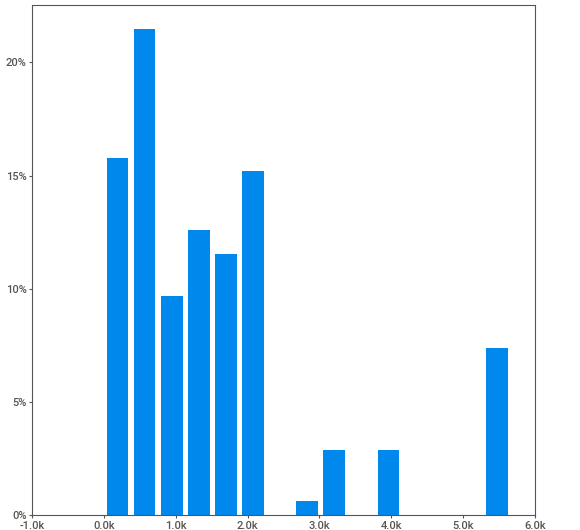
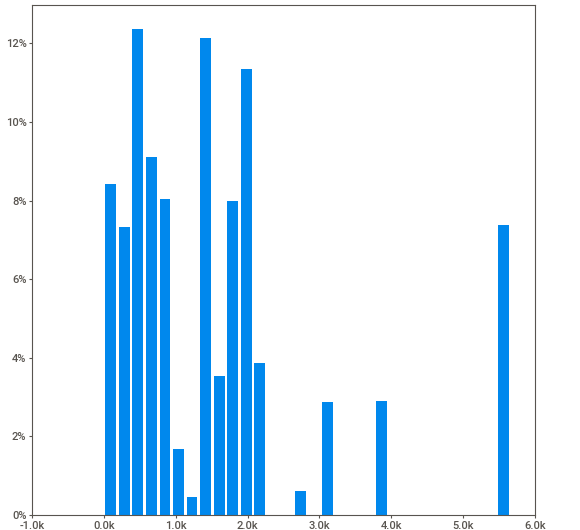
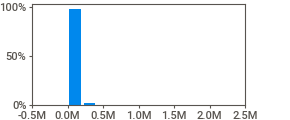
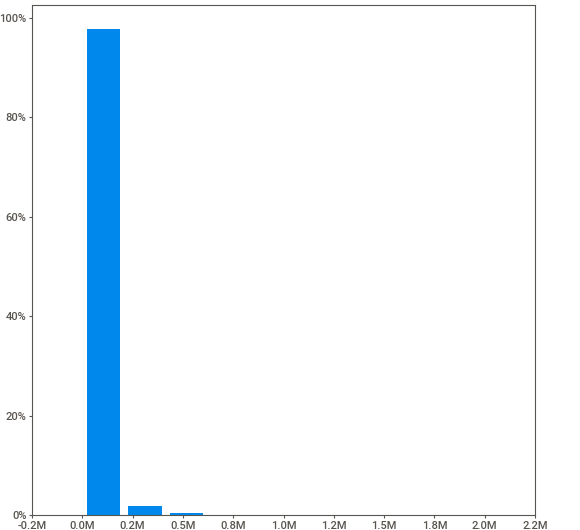
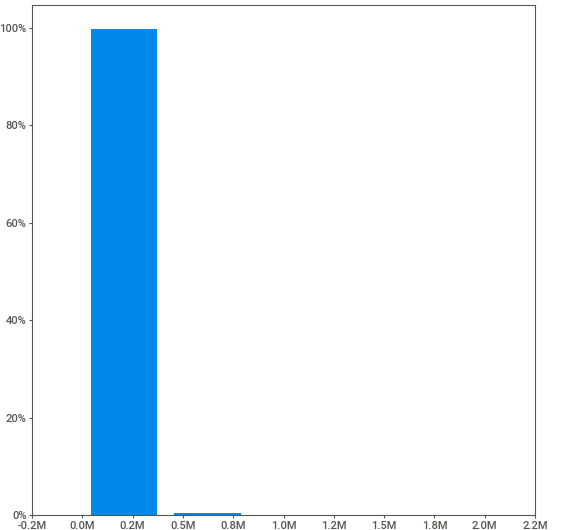
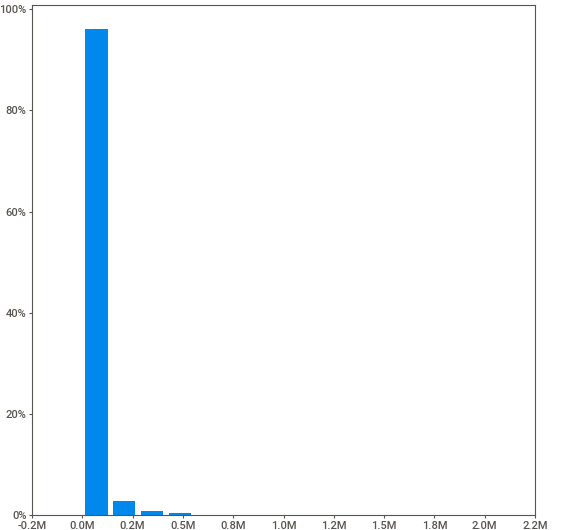
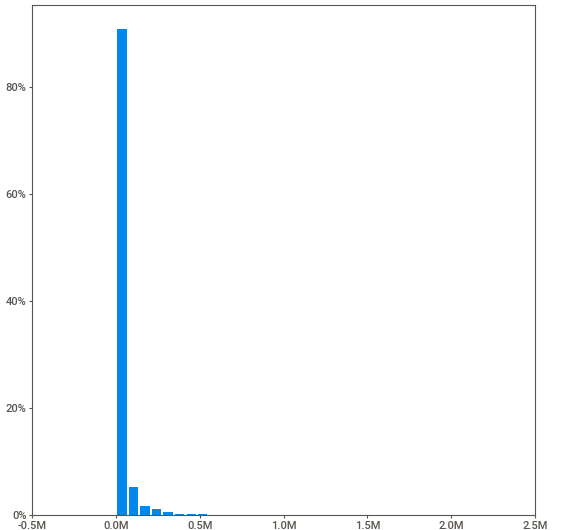
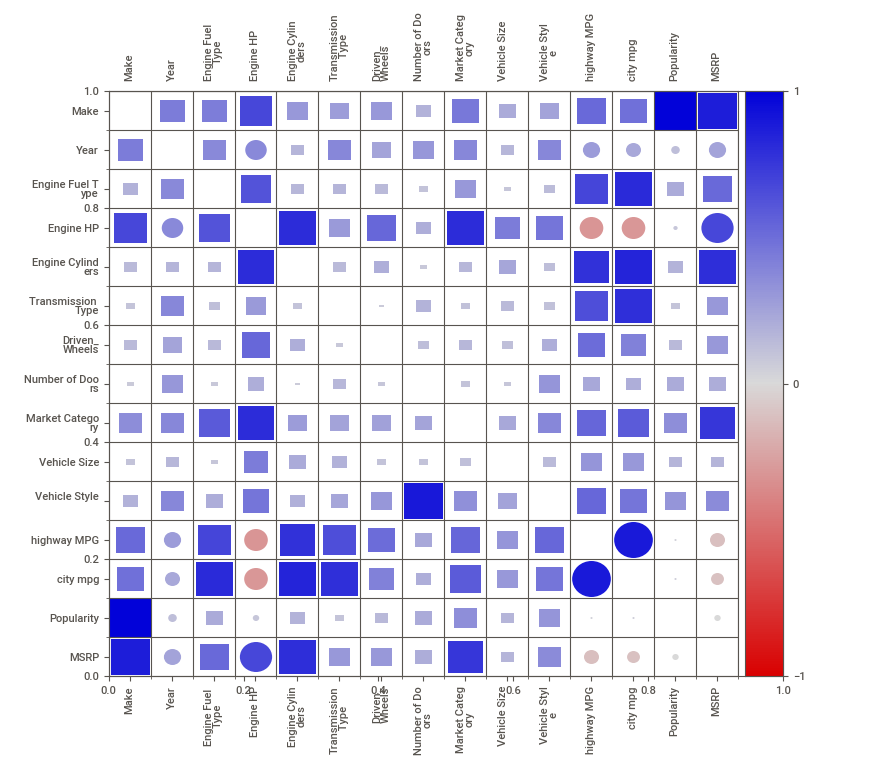
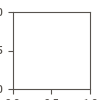

In [8]:
# Сохранение настроек для Sweetviz
sv_sets = """
[Output_Defaults]
html_layout = widescreen
html_scale = 1.0
notebook_layout = vertical
notebook_scale = 0.9
notebook_width = 100%%
notebook_height = 700
[Layout]
show_logo = 0
"""
with open("sv.ini", "w") as ini_file:
    ini_file.write(sv_sets)
sv.config_parser.read("sv.ini")
# Создание экземпляра класса и запуск метода выполнения EDAFlow
ef = EDAFlow(cm.GetConfig())
ef.Run()

# 6.Отображение лога исполнения

In [9]:
import IPython
IPython.display.HTML("<br/>".join(open('execution.log').readlines()))